In [1]:
%matplotlib inline

import os
import shutil
from collections import defaultdict

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm, tqdm_notebook

In [2]:
DATA_DIR = '../data/'

In [3]:
train_names = os.listdir(DATA_DIR + 'training/images/')
test_names = os.listdir(DATA_DIR + 'testing/images/')
names = train_names + test_names

In [4]:
def load(name):
    if not name.endswith('.tif'):
        name += '.tif'
    if name in train_names:
        return plt.imread(DATA_DIR + 'training/images/' + name)
    if name in test_names:
        return plt.imread(DATA_DIR + 'testing/images/' + name)

In [5]:
def mask(name):
    if not name.endswith('.tif'):
        name += '.tif'
    if not name in train_names:
        ValueError(name)
    name = name.replace('.tif', '_mask.png')
    return plt.imread(DATA_DIR + 'training/truth/' + name)        

In [6]:
train_images = [load(n) for n in train_names]
train_masks = [mask(n) for n in train_names]
test_images = [load(n) for n in test_names]
images = train_images + test_images

In [7]:
name2im = dict(zip(names, images))
name2msk = dict(zip(names, train_masks))

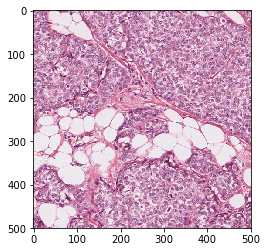

In [8]:
plt.imshow(load('i105404'))

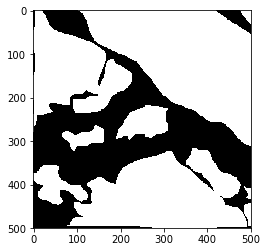

In [10]:
plt.imshow(mask('i105404'), cmap='Greys_r')

In [11]:
images = train_images + test_images
images = np.array(images)
normed = images.copy().astype(float)
normed[:, :, :, 0] -= np.mean(normed[:, :, :, 0])
normed[:, :, :, 1] -= np.mean(normed[:, :, :, 1])
normed[:, :, :, 2] -= np.mean(normed[:, :, :, 2])
normed[:, :, :, 0] /= np.std(normed[:, :, :, 0])
normed[:, :, :, 1] /= np.std(normed[:, :, :, 1])
normed[:, :, :, 2] /= np.std(normed[:, :, :, 2])

In [12]:
def lr(im1, im2):
    return np.sqrt(np.mean(np.square(im1[:, -1, :] - im2[:, 0, :])))

def rl(im1, im2):
    return np.sqrt(np.mean(np.square(im1[:, 0, :] - im2[:, -1, :])))

def ud(im1, im2):
    return np.sqrt(np.mean(np.square(im1[-1, :, :] - im2[0, :, :])))

def du(im1, im2):
    return np.sqrt(np.mean(np.square(im1[0, :, :] - im2[-1, :, :])))

def dist(im1, im2, index=False):
    d1, d2, d3, d4 = lr(im1, im2), rl(im1, im2), ud(im1, im2), du(im1, im2)
    if index:
        return np.min([d1, d2, d3, d4]), np.argmin([d1, d2, d3, d4])
    else:
        return np.min([d1, d2, d3, d4])

In [13]:
# who = pd.DataFrame([[''] * 4] * len(names), index=names, columns=['right', 'down', 'left', 'up'])
# how = pd.DataFrame(9000 * np.ones([len(names), 4]), index=names, columns=['right', 'down', 'left', 'up'])

# for i, (im1, name1) in tqdm_notebook(enumerate(zip(normed, names)), total=len(names)):
#     for j, (im2, name2) in enumerate(zip(normed, names)):
#         if j <= i:
#             continue
#         d1, d2, d3, d4 = lr(im1, im2), rl(im1, im2), ud(im1, im2), du(im1, im2)

#         if d1 < how.loc[name1, 'right']:
#             how.loc[name1, 'right'] = d1
#             who.loc[name1, 'right'] = name2
#         if d2 < how.loc[name1, 'left']:
#             how.loc[name1, 'left'] = d2
#             who.loc[name1, 'left'] = name2
#         if d3 < how.loc[name1, 'down']:
#             how.loc[name1, 'down'] = d3
#             who.loc[name1, 'down'] = name2
#         if d4 < how.loc[name1, 'up']:
#             how.loc[name1, 'up'] = d4
#             who.loc[name1, 'up'] = name2

#         if d1 < how.loc[name2, 'left']:
#             how.loc[name2, 'left'] = d1
#             who.loc[name2, 'left'] = name1
#         if d2 < how.loc[name2, 'right']:
#             how.loc[name2, 'right'] = d2
#             who.loc[name2, 'right'] = name1
#         if d3 < how.loc[name2, 'up']:
#             how.loc[name2, 'up'] = d3
#             who.loc[name2, 'up'] = name1
#         if d4 < how.loc[name2, 'down']:
#             how.loc[name2, 'down'] = d4
#             who.loc[name2, 'down'] = name1

In [14]:
# np.sum(how.values < 1.0)

In [15]:
# s = np.sort(how.values, 1)
# plt.figure(figsize=(16, 4))
# plt.hist(s[:, 0], bins=20, alpha=0.5)
# plt.hist(s[:, 1], bins=20, alpha=0.5)
# plt.hist(s[:, 2], bins=20, alpha=0.5)
# plt.hist(s[:, 3], bins=20, alpha=0.5)
# plt.show()

In [16]:
# def info(name):
#     print(how.loc[name])
#     print(who.loc[name])

In [17]:
# who[np.sum(who == 'i517527.tif', 1) > 0]

In [18]:
# info('i517527.tif')

In [19]:
bads = os.listdir('bad')
lr = {s.split('_')[0]:s.split('_')[1] for s in os.listdir('good') if s.endswith('lr.png')}
ud = {s.split('_')[0]:s.split('_')[1] for s in os.listdir('good') if s.endswith('ud.png')}
good = sum(list(map(list, lr.items())) + list(map(list, ud.items())), [])
from collections import Counter
neigh = Counter()
for g in good:
    neigh[g] += 1

In [20]:
unpaired = list(set(names) - set(neigh.keys()))
print(len(unpaired))

42


In [21]:
u = ud.keys()
l = lr.keys()
topleft = list(set(u) & set(l))
print(len(topleft))

72


In [23]:
# def color(name, image):
#     image = image.copy()
#     if name in train_names:
#         image[0, :, :] = [0, 255, 0]
#         image[-1, :, :] = [0, 255, 0]
#         image[:, 0, :] = [0, 255, 0]
#         image[:, -1, :] = [0, 255, 0]
#     else:
#         image[0, :, :] = [255, 0, 0]
#         image[-1, :, :] = [255, 0, 0]
#         image[:, 0, :] = [255, 0, 0]
#         image[:, -1, :] = [255, 0, 0]
#     return image

## Quads

In [30]:
shutil.rmtree('quads', ignore_errors=True)
shutil.rmtree('../data/quading', ignore_errors=True)
os.makedirs('quads/train')
os.makedirs('quads/truth')
os.makedirs('quads/test')
os.makedirs('../data/quading/images')
os.makedirs('../data/quading/truth')
for i, corner in enumerate(tqdm_notebook(topleft)):
    nm00 = corner
    nm01 = lr[corner]
    nm10 = ud[corner]
    nm11 = lr[ud[corner]]
    im00 = name2im[nm00]
    im01 = name2im[nm01]
    im10 = name2im[nm10]
    im11 = name2im[nm11]
    quad = np.vstack([np.hstack([im00, im01]), np.hstack([im10, im11])])
    if nm00 in train_names and nm00 in train_names and nm00 in train_names and nm00 in train_names:
        plt.imsave(f'quads/train/{nm00}_{nm01}_{nm10}_{nm11}.png', quad)
        plt.imsave(f'../data/quading/images/{nm00}_{nm01}_{nm10}_{nm11}.tif', quad)
        ms00 = name2msk[nm00]
        ms01 = name2msk[nm01]
        ms10 = name2msk[nm10]
        ms11 = name2msk[nm11]
        qmsk = np.vstack([np.hstack([ms00, ms01]), np.hstack([ms10, ms11])])
        plt.imsave(f'quads/truth/{nm00}_{nm01}_{nm10}_{nm11}.png', qmsk, cmap='Greys_r')
        plt.imsave(f'../data/quading/truth/{nm00}_{nm01}_{nm10}_{nm11}_mask.png', qmsk, cmap='Greys_r')
        np.savetxt(f'../data/quading/truth/{nm00}_{nm01}_{nm10}_{nm11}_mask.txt',
                   qmsk.T // 255, fmt='%d', delimiter='')
    elif nm00 in test_names and nm00 in test_names and nm00 in test_names and nm00 in test_names:
        plt.imsave(f'quads/test/{nm00}_{nm01}_{nm10}_{nm11}.png', quad)
    else:
        raise ValueError('Something went wrong')   

## Unpaired

In [25]:
shutil.rmtree('unpaired', ignore_errors=True)
os.makedirs('unpaired')
for un in tqdm_notebook(unpaired):
    plt.imsave('unpaired/' + un, name2im[un])

In [26]:
# THR = 0.92

# right = defaultdict(set)
# down = defaultdict(set)

# dists = 9000 * np.ones([len(images), len(images)])
# for i, (im1, name1) in tqdm_notebook(enumerate(zip(images, names)), total=len(names)):
#     if neigh[name1] == 2:
#         continue
#     for j, (im2, name2) in enumerate(zip(images, names)):
#         if i == j:
#             continue
#         if neigh[name2] == 2:
#             continue
#         dists[i, j], index = dist(im1, im2, index=True)
#         if dists[i, j] < THR:
#             if index == 0:
#                 right[name1].add(name2)
#             if index == 1:
#                 right[name2].add(name1)
#             if index == 2:
#                 down[name1].add(name2)
#             if index == 3:
#                 down[name2].add(name1)

In [27]:
# shutil.rmtree('pairs')
# os.makedirs('pairs')

# for l, rs in tqdm_notebook(right.items(), total=len(right)):
#     im1 = name2im[l].copy()
#     for r in rs:
#         im2 = name2im[r].copy()
#         im1 = cv2.putText(im1, l, (150, 250), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255, 255, 127), 5, cv2.LINE_AA)
#         im2 = cv2.putText(im2, r, (150, 250), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255, 255, 127), 5, cv2.LINE_AA)
#         path = f'pairs/{l}_{r}_lr.png'
#         if path in bads:
#             continue
#         plt.imsave(path, np.hstack([im1, im2]))

# for u, ds in tqdm_notebook(down.items(), total=len(down)):
#     im1 = name2im[u].copy()
#     for d in ds:
#         im2 = name2im[d].copy()
#         im1 = cv2.putText(im1, u, (150, 250), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255, 255, 127), 5, cv2.LINE_AA)
#         im2 = cv2.putText(im2, d, (150, 250), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255, 255, 127), 5, cv2.LINE_AA)
#         path = f'pairs/{u}_{d}_ud.png'
#         if path in bads:
#             continue
#         plt.imsave(path, np.rot90(np.vstack([im1, im2])))

In [28]:
# plt.figure(figsize=(16, 14))
# sns.heatmap(dists)

In [29]:
# print(lr(im1, im2))
# print(rl(im1, im2))
# print(ud(im1, im2))
# print(du(im1, im2))